In [1]:
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from numpy.fft import fftshift, fft2
%matplotlib

Using matplotlib backend: MacOSX


## Functions

In [2]:
class Input:
    def __init__(self, Coordinates=[], full_image=[]):
        """ Coordinates: [x1,y1,z1, x2,y2,z2] """
        
        self.Coordinates = Coordinates
        self.Full_image = full_image / full_image.max()

        # Cropping the Signal & Noise
        x1,y1,z1, x2,y2,z2 = self.Coordinates
        self.Image = full_image[x1:x2,y1:y2,z1] / full_image.max()
        
        # PSD (power spectral density)
        self.PSD = np.mean(abs(fftshift(fft2(self.Image)))**2)

    def show(self, full_image=False):
        if full_image:

            # Showing full size input
            ax = plt.subplot(111)
            plt.imshow(self.Full_image[...,self.Coordinates[2]],cmap='gray')

            # Overlaying the boundingbox
            currentAxis = plt.gca()
            x1,y1,_, x2,y2,z2 = self.Coordinates
            currentAxis.add_patch(Rectangle([y1,x1],y2-y1,x2-x1,angle=0,fill=False,color='red'))

        else:
            # Showing cropped input
            plt.imshow(self.Image,cmap='gray')

def adding_WGN(im=[], noise_mean=0, noise_std=1):
    gaussian_noise_real = np.random.normal(loc=noise_mean , scale = noise_std, size=im.shape)
    gaussian_noise_imag = np.random.normal(loc=noise_mean , scale = noise_std, size=im.shape)
    gaussian_noise = gaussian_noise_real + 1j*gaussian_noise_imag
        
    return abs(im + gaussian_noise), gaussian_noise

class measure_SNR_full_image:
    def __init__(self,noisy_image, Co_foreground, Co_background):
        self.Thalamus = Input(Coordinates=Co_foreground, full_image=noisy_image)
        self.Background = Input(Coordinates=Co_background, full_image=noisy_image)

        self.psd_noise = self.Background.PSD
        self.psd_signal = self.Thalamus.PSD - self.Background.PSD
        self.SNR1 = 10*np.log10(self.psd_signal/self.psd_noise) 

        self.SNR2 = self.Thalamus.Image.mean() / self.Background.Image.std()

def measure_SNR_cropped(signal,noise):

    PSD_signal = np.mean(abs(fftshift(fft2(signal)))**2)
    PSD_noise = np.mean(abs(fftshift(fft2(abs(noise))))**2)
    return 10*np.log10(PSD_signal/PSD_noise) 


## Old Method vs. New Method SNR Values

In [8]:
# Directory 
direcotry = r'/Users/artinmac/Google Drive/RESEARCH/Projects/Thalamus/Results/2nd Submission/SNR test/vimp2_967_08132013_KW/vimp2_orig_SNR_10000/'

noise_std = 30
n_slide = 120


# Old Method
im_cropped = nib.load(direcotry + 'PProcessed.nii.gz').get_fdata()
_, noise = adding_WGN(im_cropped, noise_mean=0, noise_std=noise_std)
SNR = measure_SNR_cropped(signal=im_cropped,noise=noise)


# New Method
im = nib.load(direcotry + 'WMnMPRAGE_bias_corr.nii.gz').get_fdata()
imN, noise = adding_WGN(im, noise_mean=0, noise_std=noise_std)
MSI = measure_SNR_full_image(noisy_image=imN , Co_foreground=[100,165, n_slide, 115, 205, n_slide+1] , Co_background = [0,0, n_slide, 50, 50, n_slide+1])

print(f'SNR Old Method -  Full Size: {MSI.SNR1:1.2f}    Cropped: {SNR:1.2f}')
print(f'SNR  - New method {MSI.SNR2:1.2f}  ->  Equivalent ->  Old method : {SNR:1.2f}   ')

SNR Old Method -  Full Size: 11.85    Cropped: 27.09
SNR  - New method 17.74  ->  Equivalent ->  Old method : 27.09   


## Plotting the Output

Text(0.5, 1.0, 'SNR:   Old Method ) =  27.1    -   New Method =  17.6')

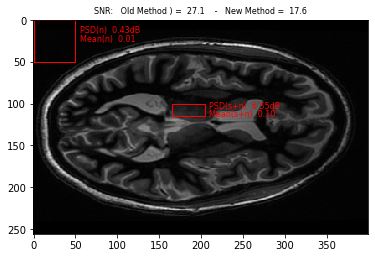

In [7]:
ax = plt.subplot(111)
plt.imshow(im[...,n_slide],cmap='gray')
currentAxis = plt.gca()

x1,y1,_, x2,y2,z2 = MSI.Thalamus.Coordinates
currentAxis.add_patch(Rectangle([y1,x1],y2-y1,x2-x1,angle=0,fill=False,color='red'))
ax.text(y2+5, x1+5, f'PSD(s+n) {MSI.psd_signal: 1.2f}dB',color='red',fontsize=8)
ax.text(y2+5, x1+15, f'Mean(s+n) {MSI.Thalamus.Image.mean(): 1.2f}',color='red',fontsize=8)

x1,y1,_, x2,y2,z2 = MSI.Background.Coordinates
currentAxis.add_patch(Rectangle([y1,x1],y2-y1,x2-x1,angle=0,fill=False,color='red'))
ax.text(y2+5, x1+15, f'PSD(n) {MSI.psd_noise: 1.2f}dB',color='red',fontsize=8)
ax.text(y2+5, x1+25, f'Mean(n) {MSI.Background.Image.mean(): 1.2f}',color='red',fontsize=8)

plt.title(f'SNR:   Old Method ) = {SNR: 1.1f}    -   New Method = {MSI.SNR2: 1.1f}',fontsize=8)

## Measuring from Template vs. Original Image

In [10]:
template = nib.load('/Users/artinmac/Google Drive/RESEARCH/Projects/Thalamus/code/general/RigidRegistration/origtemplate.nii.gz').get_fdata()
Template = Input(Coordinates=[100,165, n_slide, 115, 205, n_slide+1], full_image=template)

print(f'SNR Old Method:    From Image:  {10*np.log10((MSI.Thalamus.PSD - MSI.Background.PSD)/MSI.Background.PSD):1.2f}   From Template: {10*np.log10(Template.PSD/MSI.Background.PSD):1.2f} ')

print(f'PSD tempalte  {Template.PSD:1.2f}    PSD image  {MSI.Thalamus.PSD:1.2f}    PSD background  {MSI.Background.PSD:1.2f}')

SNR Old Method:    From Image:  11.85   From Template: 13.60 
PSD tempalte  9.92    PSD image  7.06    PSD background  0.43
